# Importe de Librerias

In [48]:
import numpy as np 
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.graph_objects as go
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , f1_score, recall_score, precision_score, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,f1_score
from sklearn.ensemble import VotingClassifier, StackingRegressor
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [49]:
ds_train = pd.read_csv('properati_argentina_ampliado_train.csv')
ds_test = pd.read_csv('properati_argentina_ampliado_test.csv')

## Preparamos los datasets para trabajar

In [50]:
ds_train.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q,property_description,piscina,balcon,patio,terraza,gimnasio,garaje
0,0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...,0,1,0,0,0,0
1,1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio,"Ubicado en Palermo, en una zona de muchos medi...",0,0,0,0,0,0
2,2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio,Corredor Responsable: Diego Enrique Mastrangel...,0,1,0,0,0,0
3,3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio,EXCELENTE DEPARTAMENTO DE 5 AMBIENTES DE 75 M2...,0,0,0,1,0,0
4,4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo,Muy buen departamento de 2 ambientes en O'Higg...,0,0,1,0,0,0


In [51]:
ds_test.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q,property_description,piscina,balcon,patio,terraza,gimnasio,garaje
0,0,1MIZ1gFNRkTXELdcBl+opQ==,-34.598679,-58.499717,Departamento,1.0,1.0,38.0,28.0,85000.0,medio,Departamento 38m² 1 ambiente con Gas Natural e...,0,0,0,0,0,0
1,1,hi5vMb1IpzsBoUGGVGPCXA==,-34.574987,-58.420611,Departamento,2.0,1.0,150.0,70.0,520000.0,alto,Depto muy exclusivo!!!! con excelente terraza ...,0,0,1,1,0,0
2,2,f57uQb0jzaTRg98/B71HOg==,-34.586527,-58.398279,Departamento,2.0,1.0,43.0,41.0,87000.0,medio,Gran Oportunidad ! Re retasado!<br>Depto. 2 am...,0,0,0,0,0,0
3,3,gsO2peJbSoSQ0hI1E5TH8g==,-34.577647,-58.406064,Departamento,4.0,3.0,130.0,118.0,690000.0,alto,<br>IMPECABLE UNIDAD DE 4 AMBIENTES CON DEPEN...,0,0,0,0,0,0
4,4,4cnMe44uQLFiAnBC1SXjUg==,-34.560998,-58.464248,Departamento,1.0,1.0,33.0,29.0,95000.0,alto,DEPARTAMENTO EN ESQUINA CON AMENITIES <br><br...,0,0,0,0,0,0


Elimino columnas 

- id no aporta nada en esta seccion del TP
- Unnamed: 0 

In [52]:
columnas_a_eliminar = ["id", "Unnamed: 0"]

ds_train.drop(columns = columnas_a_eliminar, inplace=True)
ds_test.drop(columns = columnas_a_eliminar, inplace=True)

#cambio nombre a precioxm2_relativo_q
ds_train.rename(columns={"precioxm2_relativo_q":"tipo_precio"}, inplace=True)
ds_test.rename(columns={"precioxm2_relativo_q":"tipo_precio"}, inplace=True)

#### Ingenieria de caracteristicas

Realizo dummies a la variable property_type

In [53]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)
ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

Normalizo valores variables cuantitativas

In [54]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "latitud", "longitud"]
sc = StandardScaler()

#estandarizo variables cuantitativas en train
x = ds_train.loc[:, columnas_elegidas].values
x = sc.fit_transform(x)
ds_train[columnas_elegidas] = x 

#estandarizo variables cuantitativas en test
y = ds_test.loc[:, columnas_elegidas].values
y = sc.transform(y)
ds_test[columnas_elegidas] = y


In [55]:
ds_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_description,piscina,balcon,patio,terraza,gimnasio,garaje,property_type_Departamento,property_type_PH
0,-0.226971,-0.843338,-0.572024,-0.901181,-0.360814,-0.422360,80000.0,bajo,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...,0,1,0,0,0,0,1,0
1,0.613885,0.359192,-0.572024,-0.901181,-0.611332,-0.761908,79900.0,medio,"Ubicado en Palermo, en una zona de muchos medi...",0,0,0,0,0,0,1,0
2,1.721401,-0.372818,-1.448310,-0.901181,-0.750509,-1.125710,69000.0,medio,Corredor Responsable: Diego Enrique Mastrangel...,0,1,0,0,0,0,1,0
3,-1.407153,-0.706479,2.056835,1.409468,-0.054625,0.208230,150000.0,medio,EXCELENTE DEPARTAMENTO DE 5 AMBIENTES DE 75 M2...,0,0,0,1,0,0,1,0
4,1.806656,-0.659172,-0.572024,-0.901181,-0.458238,-0.786162,85000.0,bajo,Muy buen departamento de 2 ambientes en O'Higg...,0,0,1,0,0,0,1,0


In [56]:
ds_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_description,piscina,balcon,patio,terraza,gimnasio,garaje,property_type_Departamento,property_type_PH
0,-0.105881,-1.638376,-1.448310,-0.901181,-0.569579,-0.931682,85000.0,medio,Departamento 38m² 1 ambiente con Gas Natural e...,0,0,0,0,0,0,1,0
1,0.811376,0.475542,-0.572024,-0.901181,0.989200,0.086963,520000.0,alto,Depto muy exclusivo!!!! con excelente terraza ...,0,0,1,1,0,0,1,0
2,0.364577,1.072312,-0.572024,-0.901181,-0.499991,-0.616388,87000.0,medio,Gran Oportunidad ! Re retasado!<br>Depto. 2 am...,0,0,0,0,0,0,1,0
3,0.708381,0.864258,1.180548,1.409468,0.710847,1.251129,690000.0,alto,<br>IMPECABLE UNIDAD DE 4 AMBIENTES CON DEPEN...,0,0,0,0,0,0,1,0
4,1.352950,-0.690547,-1.448310,-0.901181,-0.639168,-0.907429,95000.0,alto,DEPARTAMENTO EN ESQUINA CON AMENITIES <br><br...,0,0,0,0,0,0,1,0


# Ensambles de modelos - Dataset sin ampliar

##### Primero, vamos a evaluar los modelos usando el dataset sin ampliar del TP1

## Voting - Dataset sin ampliar

Para voting vamos a utilizar 3 modelos de clasificacion.
- Arbol de decisicion
- Random forest
- KNN

### Preparamos los datasets a utilizar

Elegimos que colunas vamos a utilizar

In [ ]:
features = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH"]

target = ["tipo_precio"]

In [ ]:
#train
x_train = ds_train[features]
y_train = ds_train[target]

#test
x_test= ds_test[features]
y_test= ds_test[target]

### Arbol de decision

#### Optimizacion de Hiperparametros

In [59]:
def optimizar_parametros(ds_train_x, ds_train_y):
    #Cantidad de combinaciones que quiero porbar
    n=20 

    #Conjunto de parámetros que quiero usar
    params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}
                    
    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree = DecisionTreeClassifier() 

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    #Random Search Cross Validation
    randomcv = RandomizedSearchCV(estimator=base_tree,
                                param_distributions = params_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                random_state=1) 


    return randomcv.fit(ds_train_x,ds_train_y)

randomcv_tree = optimizar_parametros(x_train, y_train)

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [60]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_tree.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_tree.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.002263157894736842}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5750308871072931


#### Obtenemos el mejor modelo

In [61]:
best_tree = DecisionTreeClassifier().set_params(**randomcv_tree.best_params_)

### Random Forest

#### Optimización de hiperparámetros

In [62]:
def optimizar_parametros_rf(ds_train_x, ds_train_y):
    
    #Cantidad de combinaciones que quiero porbar
    n=20


    param_grid_rf = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}

    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree_rf = RandomForestClassifier()#n_estimators=648


    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    randomcv_rf = RandomizedSearchCV(   estimator=base_tree_rf,
                                        param_distributions = param_grid_rf,
                                        cv=kfoldcv,
                                        scoring = scorer_fn,
                                        n_jobs=-1,
                                        random_state=1)

    return randomcv_rf.fit(ds_train_x, ds_train_y)



randomcv_rf = optimizar_parametros_rf(x_train, y_train)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


- Utilizamos Random Search dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizamos una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [63]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_rf.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_rf.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.002263157894736842}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5671204694676022


#### Obtenemos el mejor modelo

In [64]:
best_rand_forest = RandomForestClassifier().set_params(**randomcv_rf.best_params_)

### KNN

#### Optimizacion de parametros

In [65]:
def optimizar_parametros_knn(ds_train_x, ds_train_y): 

    #Grilla de Parámetros
    params_grid={ 'n_neighbors':range(10,30), 
                'weights':['distance','uniform'],
                'algorithm':['ball_tree', 'kd_tree', 'brute'],
                'metric':['euclidean','manhattan','chebyshev']
                }

    scorer_fn = make_scorer(f1_score, average='micro')

    #Clasificador KNN
    knn = KNeighborsClassifier()

    #Random Search con 10 Folds y 10 iteraciones
    rand = RandomizedSearchCV(knn, params_grid, scoring=scorer_fn, cv=10, n_iter=10, random_state=1)

    return rand.fit(ds_train_x, ds_train_y)

randomcv_knn = optimizar_parametros_knn(x_train, y_train)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [66]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_knn.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_knn.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'weights': 'distance', 'n_neighbors': 29, 'metric': 'manhattan', 'algorithm': 'brute'}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.7258425964391748


#### Obtenemos el mejor modelo

In [67]:
best_knn = KNeighborsClassifier().set_params(**randomcv_knn.best_params_)

### Ensamblamos los modelos

In [68]:
#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('arbol', best_tree), ('rand_forest', best_rand_forest), ('knn', best_knn)], voting = 'soft')
# soft da una mejora significativas en las metricas

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Evaluo

In [69]:
def evaluar_modelo(ds_test_x, ds_test_y, knn):

    y_pred=knn.predict(ds_test_x)

    print('F1-Score: {}'.format(f1_score(ds_test_y, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1
    #Reporte de Clasificación
    print(classification_report(ds_test_y,y_pred))

    #Matriz de Confusión
    cm = confusion_matrix(ds_test_y, y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')

F1-Score: 0.7267329061085308
              precision    recall  f1-score   support

        alto       0.79      0.59      0.67      4252
        bajo       0.79      0.61      0.69      4265
       medio       0.69      0.86      0.76      8492

    accuracy                           0.73     17009
   macro avg       0.76      0.68      0.71     17009
weighted avg       0.74      0.73      0.72     17009



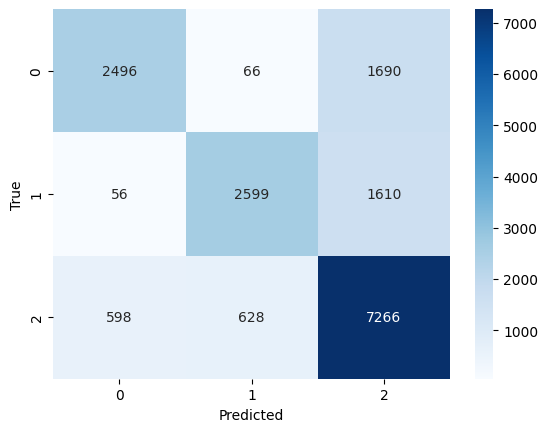

In [70]:
evaluar_modelo( x_test, y_test, vot_clf)

In [71]:
acc = accuracy_score(y_test, pred)
pre = precision_score(y_test, pred, average="macro")
rec = recall_score(y_test, pred, average="macro")
f1 = f1_score(y_test, pred, average='macro')

print("La metrica Accuracy con datos de testeo fue de: " + str(acc))
print("La metrica Precision con datos de testeo fue de: " + str(pre))
print("La metrica Recall con datos de testeo fue de: " + str(rec))
print("La metrica F1 con datos de testeo fue de: " + str(f1))

La metrica Accuracy con datos de testeo fue de: 0.7267329061085308
La metrica Precision con datos de testeo fue de: 0.7564361108177504
La metrica Recall con datos de testeo fue de: 0.6840084548711793
La metrica F1 con datos de testeo fue de: 0.7082249440444057


### Comparacion con puntos anteriores

#### Comparacion con Redes Neuronales

Comparando las metricas obtenidas en redes neuronales para clasificacion, podemos observar que las metricas obtenidas en este punto (Voting) fueron superiores

Metricas obtenidas en Redes Neuronales:

- Accuracy : 0.594
- Precision : 0.607
- Recall : 0.539
- F1 : 0.557

Metricas obtenidas en Voting con dataset sin ampliar:

- Accuracy : 0.726
- Precision : 0.756
- Recall : 0.683
- F1 : 0.708

Como podemos ver, todas las metricas evaluadas fueron mejores en el modelo elejido de Voting para clasificacion

## Stacking - Dataset sin ampliar

Para stacking vamos a utilizar 4 modelos de regresión.
- Gradient Booost
- Random forest
- KNN
- XGBoost

#### Preparamos los datasets a utilizar

Elegimos que columnas vamos a utilizar

In [72]:
features = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH"]

target = ["property_price"]

In [73]:
#train
x_train = ds_train[features]
y_train = ds_train[target]

#test
x_test= ds_test[features]
y_test= ds_test[target]

### KNN

#### Obtenemos mejores Hiperparámetros

In [74]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev', 'minkowski'],
              'leaf_size': list(range(0, 50)),
             }

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)
#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 5 Folds y 10 iteraciones
randomcv_knn_regr = RandomizedSearchCV(knn, params_grid, cv=10, scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2}, n_iter=10, random_state=5, refit='r2')
randomcv_knn_regr.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, ...],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'minkowski'],
                                        'n_neighbors': range(1, 30),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [75]:
#Mejores hiperparametros
print(randomcv_knn_regr.best_params_)

#Mejor métrica
r2 = randomcv_knn_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'weights': 'distance', 'n_neighbors': 22, 'metric': 'manhattan', 'leaf_size': 44, 'algorithm': 'brute'}
El R2 score en datos de entrnamiento: 0.8933346308333068


#### Obtenemos el mejor modelo

In [76]:
#Mejor estimador
best_knn_regr = KNeighborsRegressor().set_params(**randomcv_knn_regr.best_params_)

### XGboost

#### Optimizamos hiperparametros

In [77]:
#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'max_depth':list(range(3,10)),                    
               'random_state':list(range(0,6)),                
               'gamma':list(range(10,32)),
               'min_child_weight':list(range(10,18)),
               'colsample_bytree':np.linspace(0.75,0.8,15)}
                
#Cantidad de splits para el Cross Validation
folds=10

#Regresor
xgb_model_rd_search = xgb.XGBRegressor()

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)

#Random Search Cross Validation
randomcv_xgb_regr = RandomizedSearchCV(estimator=xgb_model_rd_search,
                              param_distributions = params_grid,
                              scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2},
                              n_iter=n, cv=folds, random_state=5, refit='r2') 


#Busco los hiperparamtros que optimizan MSE y R2
randomcv_xgb_regr.fit(x_train,y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,...
       0.76785714, 0.77142857, 0.775     , 0.77857143, 0.78214286,
       0.78571429, 0.78928571, 0.79285714, 0.79642857, 0.8       ]),
                                        'gamma': [10, 11, 12, 13, 14, 15, 16,
                                                  17, 18, 19, 20, 21, 22, 23,
                                                  24, 25, 26, 27, 28, 29, 30,
                                                  31],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [10, 11, 12, 13, 14,
                                                             15, 16, 17],
                                        'random_state': [0, 1, 2, 3, 4, 5]},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [78]:
#Mejores hiperparametros
print(randomcv_xgb_regr.best_params_)

#Mejor métrica
r2 = randomcv_xgb_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'random_state': 3, 'min_child_weight': 12, 'max_depth': 9, 'gamma': 26, 'colsample_bytree': 0.7571428571428571}
El R2 score en datos de entrnamiento: 0.89137106165189


#### Obtenemos el mejor modelo

In [79]:
#Mejor estimador
best_xgboost_regr = xgb.XGBRegressor().set_params(**randomcv_xgb_regr.best_params_)

### Gradient boost

#### Optimizamos hiperparámetros

In [80]:
#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {         'n_estimators': [50, 100], #nº de etapas de boosting
                        'learning_rate': [0.01, 0.05, 0.1], #reduce la contribucion de cada arbol por este valor 
                        'max_features': [4, 7], #nº de variables a tener en cuenta para las divisiones
                        'min_samples_split': [5, 10]} #nº mínimo de observaciones necesarias para dividir un nodo interno (n.minobsinnode en R)

                
#Cantidad de splits para el Cross Validation
folds=10

#Regresor
gb_model_rd_search = GradientBoostingRegressor()

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)

#Random Search Cross Validation
randomcv_gb_regr = RandomizedSearchCV(estimator=gb_model_rd_search,
                              param_distributions = params_grid,
                              scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2},
                              n_iter=n, cv=folds, random_state=5, refit="r2") 


#Busco los hiperparamtros que optimizan MSE y R2
randomcv_gb_regr.fit(x_train,y_train)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_features': [4, 7],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [81]:
#Mejores hiperparametros
print(randomcv_gb_regr.best_params_)

#Mejor métrica
r2 = randomcv_gb_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'n_estimators': 100, 'min_samples_split': 10, 'max_features': 7, 'learning_rate': 0.1}
El R2 score en datos de entrnamiento: 0.8342556265820974


In [82]:
#Mejor estimador
best_gradient_boost_regr = GradientBoostingRegressor().set_params(**randomcv_gb_regr.best_params_)

Obtuvimos buenas metricas en ambos, entrenamiento y testeo. Por lo que el modelo no esta overfiteado

### Random Forest

#### Optimizamos hiperparámetros

In [83]:
#Cantidad de combinaciones que quiero porbar
n=10


param_grid_rf = {
            'min_samples_leaf':list(range(1,10)),
            'min_samples_split': list(range(12,20)),
            'max_features': [4, 7],
            'ccp_alpha':np.linspace(0.001,0.005,n), 
            'max_depth':list(range(2,10)),
           }

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree_rf = RandomForestRegressor()


#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)


randomcv_rf_regr = RandomizedSearchCV(   estimator=base_tree_rf,
                                    param_distributions = param_grid_rf,
                                    cv=kfoldcv,
                                    scoring = {"mean_squared_error":scorer_fn, "r2":scorer_fn2},
                                    n_jobs=-1,
                                    random_state=1,
                                    refit="r2")

randomcv_rf_regr.fit(x_train, y_train)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.001     , 0.00144444, 0.00188889, 0.00233333, 0.00277778,
       0.00322222, 0.00366667, 0.00411111, 0.00455556, 0.005     ]),
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'max_features': [4, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [12, 13, 14, 15,
                                                              16, 17, 18, 19]},
                   random_state=1, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [84]:
#Mejores hiperparametros
print(randomcv_rf_regr.best_params_)

#Mejor métrica
r2 = randomcv_rf_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 4, 'max_depth': 8, 'ccp_alpha': 0.003666666666666667}
El R2 score en datos de entrnamiento: 0.8371657699934412


#### Obtenemos el mejor modelo

In [85]:
#Mejor estimador
best_rand_forest_regr = RandomForestRegressor().set_params(**randomcv_rf_regr.best_params_)


### Ensamblamos los modelos

In [86]:
#Modelos Base
base_models = [('random_forest',best_rand_forest_regr),
               ('xg_boost', best_xgboost_regr),
               ('gradient_boost', best_gradient_boost_regr)]

#Meta Modelo
meta_model = best_knn_regr

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=10,
                                    verbose=2)
#Entreno el ensemble
stacking_model.fit(x_train, y_train)

#Evaluo en conjunto de test
y_pred = stacking_model.predict(x_test)          

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_stacking.py:865: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_

In [87]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

r2 = metrics.r2_score(
        y_true  = y_test,
        y_pred  = y_pred,

)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")
print("El R2 score en datos de test: " + str((r2)))

El error (mse) de test es: 2235241986.5823636
El error (rmse) de test es: 47278.34585285703
El R2 score en datos de test: 0.8910737999527422


### Comparacion con puntos anteriores

#### Comparamos con punto 1 d)

Obtenemos ambas metricas

Metricas obtenidas en punto 1 d)  (Dataset ampliado con hiperparametros optimizados)

- MSE : 2667839240.610
- RMSE : 51651.130
- R2 : 0.869

Metricas obtenidas Stacking
- MSE : 2229871538.684
- RMSE : 47221.515
- R2 : 0.891

Como podemos obervar, las metricas obtenidas en stacking fueron superiores a las metricas obtenidas en el punto 1 d)

#### Comparacion con Redes Neuronales

Obtenemos las metricas obtenidas en redes neuronales para regresion

- MSE : 6,596,545,988.51
- RMSE : 81,219.12
- R2 : 0.678

Obtenemos las metricas obtenidas en Stacking con dataset sin ampliar

- MSE: 2229871538.684
- RMSE: 47,221.515
- R2 : 0.891

Como se puede apreciar, las metricas obtenidas en stacking son superiores a lo obtenido en Redes Neuronales para regresion

# Ensamble de modelos - Dataset ampliado

#### Ahora, vamos a usar evaluar los modelos con el dataset ampliado

## Voting - Dataset ampliado

Para voting vamos a utilizar 3 modelos de clasificacion.
- Arbol de decisicion
- Random forest
- KNN

### Preparo los datasets a utilizar

Decidimos que columnas vamos a utilizar

In [ ]:
features = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH", "piscina", "garaje", "patio", "terraza", "balcon", "gimnasio"]

target = ["tipo_precio"]

In [ ]:
#train
x_train_ampliado = ds_train[features]
y_train_ampliado = ds_train[target]

#test
x_test_ampliado = ds_test[features]
y_test_ampliado = ds_test[target]

### Árbol De Decisión

#### Optimización de hiperparámetros

In [93]:
def optimizar_parametros(ds_train_x, ds_train_y):
    #Cantidad de combinaciones que quiero porbar
    n=20 

    #Conjunto de parámetros que quiero usar
    params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}
                    
    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree = DecisionTreeClassifier() 

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    #Random Search Cross Validation
    randomcv = RandomizedSearchCV(estimator=base_tree,
                                param_distributions = params_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                random_state=1) 


    return randomcv.fit(ds_train_x,ds_train_y)

randomcv_tree = optimizar_parametros(x_train_ampliado, y_train_ampliado)

- Utilizamos Random Search dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizamos una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [94]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_tree.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_tree.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 6, 'max_depth': 9, 'criterion': 'entropy', 'ccp_alpha': 0.003105263157894737}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5912193737529561


#### Obtenemos el mejor modelo

In [95]:
best_tree = DecisionTreeClassifier().set_params(**randomcv_tree.best_params_)

### Random Forest

#### Optimización de hiperparámetros

In [96]:
def optimizar_parametros_rf(ds_train_x, ds_train_y):
    
    #Cantidad de combinaciones que quiero porbar
    n=20


    param_grid_rf = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}

    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree_rf = RandomForestClassifier()#n_estimators=648


    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    randomcv_rf = RandomizedSearchCV(   estimator=base_tree_rf,
                                        param_distributions = param_grid_rf,
                                        cv=kfoldcv,
                                        scoring = scorer_fn,
                                        n_jobs=-1,
                                        random_state=1)

    return randomcv_rf.fit(ds_train_x, ds_train_y)



randomcv_rf = optimizar_parametros_rf(x_train_ampliado, y_train_ampliado)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


- Utilizamos Random Search dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizamos una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [97]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_rf.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_rf.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.002263157894736842}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5803830303938994


#### Obtenemos el mejor modelo

In [98]:
best_rand_forest = RandomForestClassifier().set_params(**randomcv_rf.best_params_)

### KNN

#### Optimización de hiperparámetros

In [99]:
def optimizar_parametros_knn(ds_train_x, ds_train_y): 

    #Grilla de Parámetros
    params_grid={ 'n_neighbors':range(10,30), 
                'weights':['distance','uniform'],
                'algorithm':['ball_tree', 'kd_tree', 'brute'],
                'metric':['euclidean','manhattan','chebyshev']
                }

    scorer_fn = make_scorer(f1_score, average='micro')

    #Clasificador KNN
    knn = KNeighborsClassifier()

    #Random Search con 10 Folds y 10 iteraciones
    rand = RandomizedSearchCV(knn, params_grid, scoring=scorer_fn, cv=10, n_iter=10, random_state=1)

    return rand.fit(ds_train_x, ds_train_y)

randomcv_knn = optimizar_parametros_knn(x_train_ampliado, y_train_ampliado)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

- Utilizamos Random Search dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones

In [100]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_knn.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_knn.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'weights': 'distance', 'n_neighbors': 29, 'metric': 'manhattan', 'algorithm': 'brute'}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.7248868351814151


#### Obtenemos el mejor modelo

In [101]:
best_knn = KNeighborsClassifier().set_params(**randomcv_knn.best_params_)

### Ensamblamos los modelos

In [102]:
#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('arbol', best_tree), ('rand_forest', best_rand_forest), ('knn', best_knn)], voting = 'soft')
# soft da una mejora significativas en las metricas

#Entreno el ensemble
vot_clf.fit(x_train_ampliado, y_train_ampliado)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test_ampliado)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Evalúo

F1-Score: 0.7249103415838674
              precision    recall  f1-score   support

        alto       0.83      0.56      0.67      4252
        bajo       0.77      0.62      0.69      4265
       medio       0.68      0.86      0.76      8492

    accuracy                           0.72     17009
   macro avg       0.76      0.68      0.71     17009
weighted avg       0.74      0.72      0.72     17009



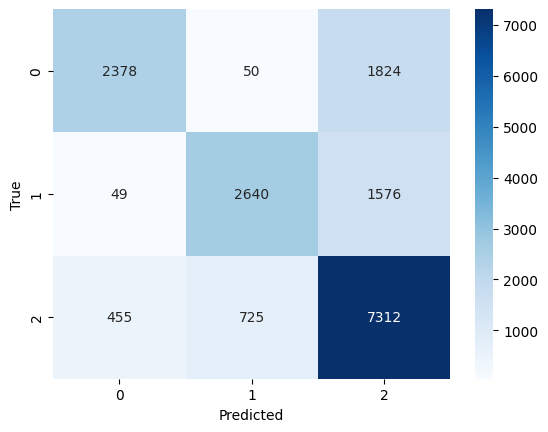

In [103]:
def evaluar_modelo(ds_test_x, ds_test_y, knn):

    y_pred=knn.predict(ds_test_x)

    print('F1-Score: {}'.format(f1_score(ds_test_y, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1
    #Reporte de Clasificación
    print(classification_report(ds_test_y,y_pred))

    #Matriz de Confusión
    cm = confusion_matrix(ds_test_y, y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    
evaluar_modelo( x_test_ampliado, y_test_ampliado, vot_clf)

In [104]:
acc = accuracy_score(y_test_ampliado, pred)
pre = precision_score(y_test_ampliado, pred, average="macro")
rec = recall_score(y_test_ampliado, pred, average="macro")
f1 = f1_score(y_test_ampliado, pred, average='macro')

print("La metrica Accuracy con datos de testeo fue de: " + str(acc))
print("La metrica Precision con datos de testeo fue de: " + str(pre))
print("La metrica Recall con datos de testeo fue de: " + str(rec))
print("La metrica F1 con datos de testeo fue de: " + str(f1))

La metrica Accuracy con datos de testeo fue de: 0.7249103415838674
La metrica Precision con datos de testeo fue de: 0.7602601423894152
La metrica Recall con datos de testeo fue de: 0.6797679037960697
La metrica F1 con datos de testeo fue de: 0.7052248952764472


### Comparamos con puntos anteriores

Metricas obtenidas en Redes Neuronales:

- Accuracy : 0.594
- Precision : 0.607
- Recall : 0.539
- F1 : 0.557

Metricas obtenidas en Voting con dataset sin ampliar:

- Accuracy : 0.726
- Precision : 0.756
- Recall : 0.683
- F1 : 0.708

Metricas obtenidas en Voting con dataset ampliado:

- Accuracy : 0.724
- Precision : 0.760
- Recall : 0.679
- F1 : 0.705

Si comparamos las metricas dadas por el ensamble de Voting (con dataset ampliado) con las de Redes Neuronales, podemos ver una mejora significativa. Al comparar con el ensamble de Voting (con dataset sin ampliar), podemos concluir que no hay mejora. Las metricas son muy similares

## Stacking - Dataset ampliado

Para voting vamos a utilizar 4 modelos de regresión.
- Gradient Boost
- Random forest
- KNN
- XGBoost

### Preparamos los datasets a utilizar

In [110]:
features = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH", "piscina", "terraza", "patio", "balcon", "garaje", "gimnasio"]

target = ["property_price"]

In [111]:
#train
x_train_ampliado = ds_train[features]
y_train_ampliado = ds_train[target]

#test
x_test_ampliado = ds_test[features]
y_test_ampliado = ds_test[target]

### KNN

#### Optimizamos hiperparámetros

In [112]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev', 'minkowski'],
              'leaf_size': list(range(0, 50)),
             }

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)
#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 5 Folds y 10 iteraciones
randomcv_knn_regr = RandomizedSearchCV(knn, params_grid, cv=10, scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2}, n_iter=10, random_state=5, refit='r2')
randomcv_knn_regr.fit(x_train_ampliado, y_train_ampliado)

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, ...],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'minkowski'],
                                        'n_neighbors': range(1, 30),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [113]:
#Mejores hiperparametros
print(randomcv_knn_regr.best_params_)

#Mejor métrica
r2 = randomcv_knn_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'weights': 'distance', 'n_neighbors': 22, 'metric': 'manhattan', 'leaf_size': 44, 'algorithm': 'brute'}
El R2 score en datos de entrnamiento: 0.8968107871260017


#### Obtenemos el mejor modelo

In [114]:
#Mejor estimador
best_knn_regr = KNeighborsRegressor().set_params(**randomcv_knn_regr.best_params_)

### XGBoost

#### Optimizamos hiperparámetros

In [115]:
#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'max_depth':list(range(3,10)),                    
               'random_state':list(range(0,6)),                
               'gamma':list(range(10,32)),
               'min_child_weight':list(range(10,18)),
               'colsample_bytree':np.linspace(0.75,0.8,15)}
                
#Cantidad de splits para el Cross Validation
folds=10

#Regresor
xgb_model_rd_search = xgb.XGBRegressor()

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)

#Random Search Cross Validation
randomcv_xgb_regr = RandomizedSearchCV(estimator=xgb_model_rd_search,
                              param_distributions = params_grid,
                              scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2},
                              n_iter=n, cv=folds, random_state=5, refit='r2') 


#Busco los hiperparamtros que optimizan MSE y R2
randomcv_xgb_regr.fit(x_train_ampliado,y_train_ampliado)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,...
       0.76785714, 0.77142857, 0.775     , 0.77857143, 0.78214286,
       0.78571429, 0.78928571, 0.79285714, 0.79642857, 0.8       ]),
                                        'gamma': [10, 11, 12, 13, 14, 15, 16,
                                                  17, 18, 19, 20, 21, 22, 23,
                                                  24, 25, 26, 27, 28, 29, 30,
                                                  31],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [10, 11, 12, 13, 14,
                                                             15, 16, 17],
                                        'random_state': [0, 1, 2, 3, 4, 5]},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [116]:
#Mejores hiperparametros
print(randomcv_xgb_regr.best_params_)

#Mejor métrica
r2 = randomcv_xgb_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'random_state': 3, 'min_child_weight': 12, 'max_depth': 9, 'gamma': 26, 'colsample_bytree': 0.7571428571428571}
El R2 score en datos de entrnamiento: 0.9057005571834328


#### Obtenemos el mejor modelo

In [117]:
#Mejor estimador
best_xgboost_regr = xgb.XGBRegressor().set_params(**randomcv_xgb_regr.best_params_)

### Gradient Boost

#### Optimizamos hiperparámetros

In [118]:
#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {         'n_estimators': [50, 100], #nº de etapas de boosting
                        'learning_rate': [0.01, 0.05, 0.1], #reduce la contribucion de cada arbol por este valor 
                        'max_features': [4, 7], #nº de variables a tener en cuenta para las divisiones
                        'min_samples_split': [5, 10]} #nº mínimo de observaciones necesarias para dividir un nodo interno (n.minobsinnode en R)

                
#Cantidad de splits para el Cross Validation
folds=10

#Regresor
gb_model_rd_search = GradientBoostingRegressor()

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)

#Random Search Cross Validation
randomcv_gb_regr = RandomizedSearchCV(estimator=gb_model_rd_search,
                              param_distributions = params_grid,
                              scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2},
                              n_iter=n, cv=folds, random_state=5, refit="r2") 


#Busco los hiperparamtros que optimizan MSE y R2
randomcv_gb_regr.fit(x_train_ampliado, y_train_ampliado)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_features': [4, 7],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [119]:
#Mejores hiperparametros
print(randomcv_gb_regr.best_params_)

#Mejor métrica
r2 = randomcv_gb_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'n_estimators': 100, 'min_samples_split': 10, 'max_features': 7, 'learning_rate': 0.1}
El R2 score en datos de entrnamiento: 0.8508890595639222


#### Obtenemos el mejor modelo

In [120]:
#Mejor estimador
best_gradient_boost_regr = GradientBoostingRegressor().set_params(**randomcv_gb_regr.best_params_)

### Random Forest

#### Optimizamos hiperparámetros

In [121]:
#Cantidad de combinaciones que quiero porbar
n=10


param_grid_rf = {
            'min_samples_leaf':list(range(1,10)),
            'min_samples_split': list(range(12,20)),
            'max_features': [4, 7],
            'ccp_alpha':np.linspace(0.001,0.005,n), 
            'max_depth':list(range(2,10)),
           }

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree_rf = RandomForestRegressor()


#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)


randomcv_rf_regr = RandomizedSearchCV(   estimator=base_tree_rf,
                                    param_distributions = param_grid_rf,
                                    cv=kfoldcv,
                                    scoring = {"mean_squared_error":scorer_fn, "r2":scorer_fn2},
                                    n_jobs=-1,
                                    random_state=1,
                                    refit="r2")

randomcv_rf_regr.fit(x_train_ampliado, y_train_ampliado)

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.001     , 0.00144444, 0.00188889, 0.00233333, 0.00277778,
       0.00322222, 0.00366667, 0.00411111, 0.00455556, 0.005     ]),
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'max_features': [4, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [12, 13, 14, 15,
                                                              16, 17, 18, 19]},
                   random_state=1, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar r2 score y mean squared error

In [ ]:
#Mejores hiperparametros
print(randomcv_rf_regr.best_params_)

#Mejor métrica
r2 = randomcv_rf_regr.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

#### Obtenemos el mejor modelo

In [122]:
#Mejor estimador
best_rand_forest_regr = RandomForestRegressor().set_params(**randomcv_rf_regr.best_params_)

###  Ensamblamos los modelos

In [124]:
#Modelos Base
base_models = [('random_forest',best_rand_forest_regr),
               ('xg_boost', best_xgboost_regr),
               ('gradient_boost', best_gradient_boost_regr)]

#Meta Modelo
meta_model = best_knn_regr

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=10,
                                    verbose=2)
#Entreno el ensemble
stacking_model.fit(x_train_ampliado, y_train_ampliado)

#Evaluo en conjunto de test
y_pred = stacking_model.predict(x_test_ampliado)          

C:\Users\Fabiana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_stacking.py:865: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_

In [125]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred,
        squared = False
       )

r2 = metrics.r2_score(
        y_true  = y_test_ampliado,
        y_pred  = y_pred,

)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")
print("El R2 score en datos de test: " + str((r2)))

El error (mse) de test es: 1989395169.6992414
El error (rmse) de test es: 44602.636353687005
El R2 score en datos de test: 0.9030542296858725


### Comparamos con puntos anteriores

#### Comparamos con punto 1d) y Redes Neuronales

Metricas obtenidas en punto 1 d)  (Dataset ampliado con hiperparametros optimizados)

- MSE : 2667839240.610
- RMSE : 51651.130
- R2 : 0.869

Obtenemos las metricas obtenidas en redes neuronales para regresion

- MSE : 6,596,545,988.51
- RMSE : 81,219.12
- R2 : 0.678

Obtenemos las metricas obtenidas en Stacking con dataset sin ampliar

- MSE: 2229871538.684
- RMSE: 47,221.515
- R2 : 0.891

Obtenemos las métricas en Stacking con dataset ampliado:

- MSE: 1989395169.6992414
- RMSE: 44602.636353687005
- R2: 0.9030542296858725

Se puede observar un clara mejora entre las métricas obtenidas con Stacking (con dataset ampliado) y las de Redes Neuronales. En cuanto a las metricas del punto 1d), podemos notar que, si bien son más parecidas, hay una mejora significativa. Por ultimo, si compramos las métricas de los ensambles de Stacking, vemos que hay una leve mejora en el ensamble que usa el dataset ampliado

# Conclusiones

Luego de analizar las métricas de todos los modelos, concluimos que para clasificación, ambos ensambles de Voting performan de forma similar a pesar de la diferencia en los datasets. Por lo tanto, a la hora de elegir, podemos usar cualquiera de los dos ensambles.
En cuanto a regresión, analizando las métricas, llegamos a la conclusión de que el ensamble de Stacking que usa el dataset ampliado performa mejor que el que usa el dataset sin ampliar. De esta forma, podemos afrimar que es más conveniente utilizar el ensamble con dataset ampliado.